In [3]:
!pip install transformers

In [5]:
import pandas as pd

# Load the dataset. Based on common versions of ecommerceDataset.csv, it has no header.
df = pd.read_csv('/content/ecommerceDataset.csv', names=['category', 'description'], header=None)

In [6]:
df.head()

,category,description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     50425 non-null  object
 1   description  50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


In [8]:
df.dropna(inplace=True)

In [9]:
df = df.drop_duplicates()

In [10]:
df['category'].value_counts()

,count
category,
Household,10564
Books,6256
Clothing & Accessories,5674
Electronics,5308


In [11]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Encode the category column and create a new 'label' column
df['label'] = le.fit_transform(df['category'])

# Print the mapping to verify
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f'Label Mapping: {mapping}')
print(df[['category', 'label']].head())

Label Mapping: {'Books': np.int64(0), 'Clothing & Accessories': np.int64(1), 'Electronics': np.int64(2), 'Household': np.int64(3)}
    category  label
0  Household      3
1  Household      3
2  Household      3
3  Household      3
4  Household      3


# BERT Tokenizer

In [12]:
from transformers import BertTokenizer

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(texts):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
# Apply tokenization to the first few descriptions to verify the output format
sample_tokens = tokenize_function(df['description'].head())
print(f'Keys in tokenized output: {sample_tokens.keys()}')
print(f'Input IDs shape: {sample_tokens["input_ids"].shape}')
print(f'Attention Mask shape: {sample_tokens["attention_mask"].shape}')

Keys in tokenized output: KeysView({'input_ids': tensor([[  101,  3259,  4946,  2640, 10366,  2813,  5689, 14354,  2389,  2436,
         25545,  2396, 11204,  1006,  1022,  1012,  1021,  1060,  1022,  1012,
          1021,  4960,  1007,  1011,  2275,  1997,  1018,  4169,  2081,  2039,
          1999, 12553,  4853,  2007, 23068, 14902,  2094,  6140,  2029,  3957,
          4800,  3896,  1998, 17771,  2875,  2009,  1012,  2023,  2003,  2019,
          2569,  2186,  1997,  5265,  2029,  3084,  2115,  2813,  2200,  3376,
          1998,  3957,  1037,  2548,  3543,  1012,  2023,  4169,  2003,  3201,
          2000,  6865,  1010,  2017,  2052,  2022,  7098,  2000, 10295,  2023,
          4310,  4169,  2008,  2003,  1037, 18111,  4237,  1012,  2057,  2224,
          2069,  1996,  2087,  2715,  1998,  8114,  8021,  2974,  2006,  2256,
         11204,  1010,  2007,  2069,  1996,  1998, 10710,  2015,  1998, 11718,
         20383,  2239,  1010,  8262,  1998,  6522, 23557,  1012,  2023,  9525,
   

In [14]:
from sklearn.model_selection import train_test_split

# Final check for nulls or empty strings in description
df = df[df['description'].fillna('').str.strip() != '']
df.dropna(subset=['description'], inplace=True)

# Split the dataframe into train (80%) and validation (20%) sets
# Using stratify to maintain class distribution and random_state for reproducibility
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Reset index for both dataframes to ensure clean indexing for PyTorch Dataset
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f'Training set size: {len(train_df)}')
print(f'Validation set size: {len(val_df)}')
print('\nTraining label distribution:\n', train_df['label'].value_counts(normalize=True))
print('\nValidation label distribution:\n', val_df['label'].value_counts(normalize=True))

Training set size: 22241
Validation set size: 5561

Training label distribution:
 label
3    0.379974
0    0.225035
1    0.204083
2    0.190909
Name: proportion, dtype: float64

Validation label distribution:
 label
3    0.379968
0    0.224960
1    0.204100
2    0.190973
Name: proportion, dtype: float64


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

class EcommerceDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer, max_length=128):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        text = str(self.descriptions[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Instantiate datasets
train_dataset = EcommerceDataset(train_df['description'], train_df['label'], tokenizer)
val_dataset = EcommerceDataset(val_df['description'], val_df['label'], tokenizer)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print(f'Train DataLoader batches: {len(train_loader)}')
print(f'Validation DataLoader batches: {len(val_loader)}')

# Quick verification of one batch
sample_batch = next(iter(train_loader))
print(f'Batch keys: {sample_batch.keys()}')
print(f'Input IDs shape: {sample_batch["input_ids"].shape}')

Train DataLoader batches: 696
Validation DataLoader batches: 174
Batch keys: dict_keys(['input_ids', 'attention_mask', 'label'])
Input IDs shape: torch.Size([32, 128])


## Initialize BERT for Classification


In [18]:
from transformers import BertForSequenceClassification
import torch

# 1. Load a fresh instance of bert-base-uncased with 4 labels
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=4
)

# 2. Freeze the BERT backbone parameters
# In BertForSequenceClassification, the backbone is accessed via .bert
for param in model.bert.parameters():
    param.requires_grad = False

# 3. Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 4. Verify that backbone is frozen and head is trainable
backbone_frozen = not next(model.bert.parameters()).requires_grad
head_trainable = next(model.classifier.parameters()).requires_grad

print(f'Model moved to: {device}')
print(f'Backbone parameters frozen: {backbone_frozen}')
print(f'Classification head trainable: {head_trainable}')

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model moved to: cuda
Backbone parameters frozen: True
Classification head trainable: True


In [19]:
from torch.optim import AdamW
import torch.nn as nn

# 1. Initialize optimizer for the fresh model's trainable parameters (the head)
fresh_optimizer = AdamW(model.parameters(), lr=5e-4)
loss_fn = nn.CrossEntropyLoss()

# 2. Train the classification head for 3 epochs
epochs = 3
print(f'Training the fresh BERT classification head for {epochs} epochs...')

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_idx, batch in enumerate(train_loader):
        # Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        fresh_optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        loss.backward()
        fresh_optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')

print('Training of the frozen BERT classification head complete.')

Training the fresh BERT classification head for 3 epochs...
Epoch 1/3, Average Loss: 0.9376
Epoch 2/3, Average Loss: 0.6524
Epoch 3/3, Average Loss: 0.5607
Training of the frozen BERT classification head complete.


In [20]:
from sklearn.metrics import accuracy_score

# 1. Put model in evaluation mode
model.eval()

val_preds = []
val_labels = []

print('Starting validation...')

# 2. Iterate through val_loader without gradient calculation
with torch.no_grad():
    for batch in val_loader:
        # 3. Move data to device and perform forward pass
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)

        # 4. Collect predicted and true labels
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# 5. Calculate and print overall validation accuracy
val_accuracy = accuracy_score(val_labels, val_preds)
print(f'Validation Accuracy: {val_accuracy:.4f}')

Starting validation...
Validation Accuracy: 0.8579


--- Classification Report ---
                        precision    recall  f1-score   support

                 Books       0.90      0.91      0.90      1251
Clothing & Accessories       0.89      0.91      0.90      1135
           Electronics       0.74      0.90      0.81      1062
             Household       0.89      0.78      0.83      2113

              accuracy                           0.86      5561
             macro avg       0.86      0.87      0.86      5561
          weighted avg       0.86      0.86      0.86      5561



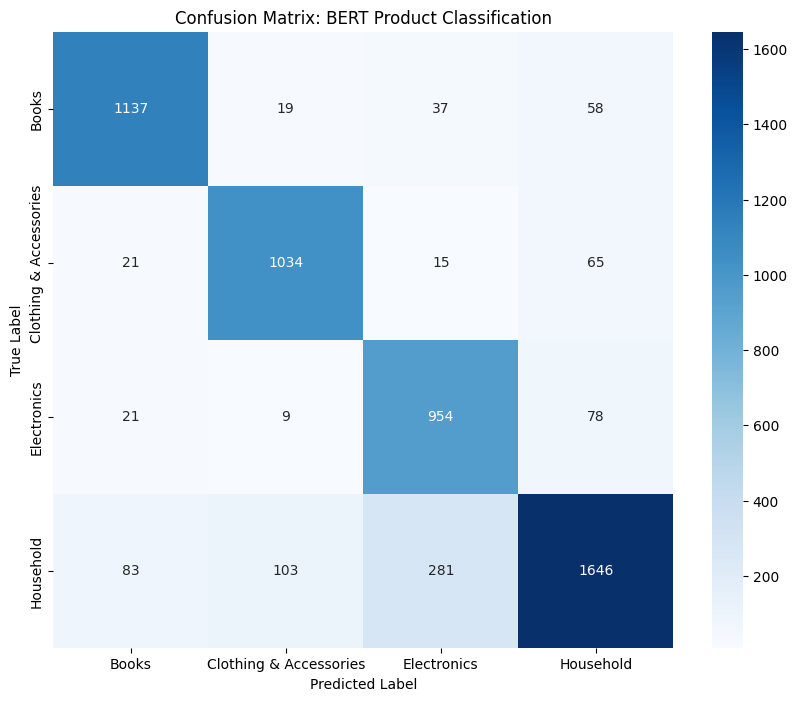

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Generate and print the classification report
# le.classes_ contains the mapping: ['Books', 'Clothing & Accessories', 'Electronics', 'Household']
target_names = le.classes_.tolist()
print('--- Classification Report ---')
print(classification_report(val_labels, val_preds, target_names=target_names))

# 2. Compute the confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# 3. Visualize the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names
)
plt.title('Confusion Matrix: BERT Product Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Bert + Logistic Regression

In [22]:
# 1. Freeze BERT model parameters
for param in model.parameters():
    param.requires_grad = False

# 2. Define a function to extract [CLS] token embeddings
def extract_cls_embeddings(model, dataloader, device):
    model.eval()
    all_embeddings = []
    all_labels = []

    print("Extracting [CLS] embeddings...")
    with torch.no_grad():
        for batch in dataloader:
            # Move inputs to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label']

            # Forward pass through BERT
            # output_hidden_states=True is usually not needed for last_hidden_state if using the base model
            # but BertForSequenceClassification might need access to the base bert model attribute
            outputs = model.bert(input_ids, attention_mask=attention_mask)

            # 3. Access last_hidden_state and select [CLS] token (index 0)
            last_hidden_state = outputs.last_hidden_state
            cls_embeddings = last_hidden_state[:, 0, :]

            # 4. Store embeddings and labels
            all_embeddings.append(cls_embeddings.cpu())
            all_labels.append(labels)

    # Concatenate all batches
    return torch.cat(all_embeddings).numpy(), torch.cat(all_labels).numpy()

print("BERT parameters frozen. Embedding extraction function defined.")

BERT parameters frozen. Embedding extraction function defined.


In [23]:
from sklearn.linear_model import LogisticRegression

# 1. Extract [CLS] embeddings for training and validation sets
X_train_cls, y_train_cls = extract_cls_embeddings(model, train_loader, device)
X_val_cls, y_val_cls = extract_cls_embeddings(model, val_loader, device)

# 2. Initialize the Logistic Regression model
# Increasing max_iter to 1000 to ensure convergence with high-dimensional embeddings
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# 3. Fit the model on training embeddings
print("Training Logistic Regression head...")
lr_model.fit(X_train_cls, y_train_cls)

# 4. Generate predictions for the validation set
lr_val_preds = lr_model.predict(X_val_cls)

print(f'Training embeddings shape: {X_train_cls.shape}')
print(f'Validation embeddings shape: {X_val_cls.shape}')
print("Logistic Regression model trained and validation predictions generated.")

Extracting [CLS] embeddings...
Extracting [CLS] embeddings...
Training Logistic Regression head...
Training embeddings shape: (22241, 768)
Validation embeddings shape: (5561, 768)
Logistic Regression model trained and validation predictions generated.


--- Logistic Regression (Frozen BERT Embeddings) Classification Report ---
                        precision    recall  f1-score   support

                 Books       0.95      0.92      0.93      1251
Clothing & Accessories       0.95      0.96      0.95      1135
           Electronics       0.90      0.91      0.90      1062
             Household       0.92      0.93      0.93      2113

              accuracy                           0.93      5561
             macro avg       0.93      0.93      0.93      5561
          weighted avg       0.93      0.93      0.93      5561



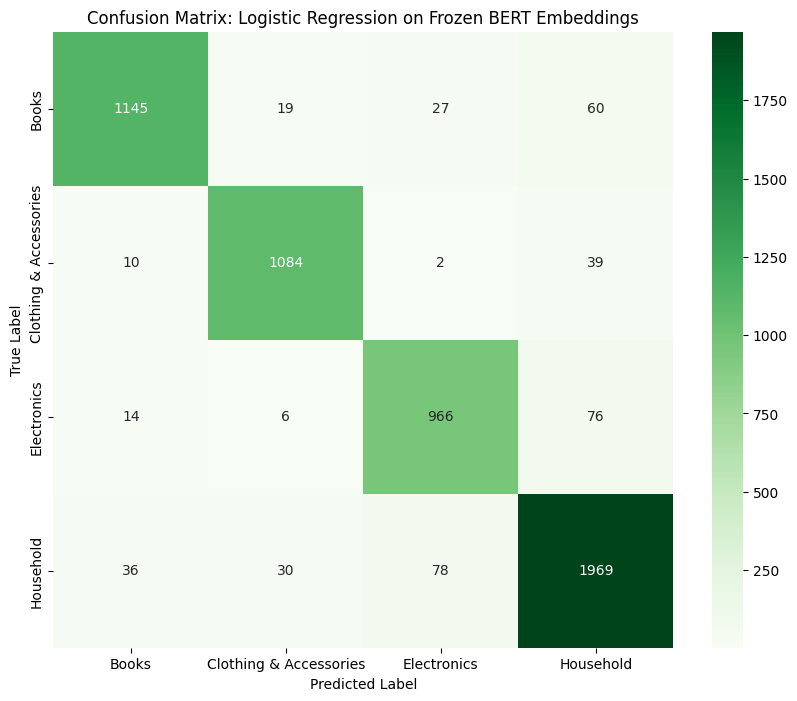


--- Performance Comparison Summary ---
Fine-tuned BERT Accuracy: 0.8579
Logistic Regression (Frozen) Accuracy: 0.9286
Accuracy Difference: -0.0707


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Generate and print the classification report for Logistic Regression
print('--- Logistic Regression (Frozen BERT Embeddings) Classification Report ---')
print(classification_report(y_val_cls, lr_val_preds, target_names=target_names))

# 2. Compute the confusion matrix for Logistic Regression
cm_lr = confusion_matrix(y_val_cls, lr_val_preds)

# 3. Visualize the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_lr,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=target_names,
    yticklabels=target_names
)
plt.title('Confusion Matrix: Logistic Regression on Frozen BERT Embeddings')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 4. Comparative Analysis (Manual observation of metrics)
print('\n--- Performance Comparison Summary ---')
print(f'Fine-tuned BERT Accuracy: {val_accuracy:.4f}')
lr_accuracy = (lr_val_preds == y_val_cls).mean()
print(f'Logistic Regression (Frozen) Accuracy: {lr_accuracy:.4f}')
print(f'Accuracy Difference: {val_accuracy - lr_accuracy:.4f}')

# Zero-Shot Learning


In [49]:
# Final optimization: balancing technical and consumer terms for Electronics
class_descriptions = [
    "This is a printed book, novel, textbook, or literature involving reading pages, authors, and publishing.",
    "This item is wearable clothing, apparel, fashion garments, footwear, or stylistic accessories like bags and jewelry.",
    "This is an electronic product such as a camera, laptop, smartphone, headphone, or digital gadget with technical hardware.",
    "This item is for home improvement, furniture, kitchenware, interior decor, or general domestic household utility."
]

# Display the mapping for verification
for i, desc in enumerate(class_descriptions):
    print(f"Label {i} ({target_names[i]}): {desc}")

Label 0 (Books): This is a printed book, novel, textbook, or literature involving reading pages, authors, and publishing.
Label 1 (Clothing & Accessories): This item is wearable clothing, apparel, fashion garments, footwear, or stylistic accessories like bags and jewelry.
Label 2 (Electronics): This is an electronic product such as a camera, laptop, smartphone, headphone, or digital gadget with technical hardware.
Label 3 (Household): This item is for home improvement, furniture, kitchenware, interior decor, or general domestic household utility.


In [50]:
import torch

# Re-extract embeddings with the balanced descriptions
class_inputs = tokenizer(
    class_descriptions,
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='pt'
)

class_input_ids = class_inputs['input_ids'].to(device)
class_attention_mask = class_inputs['attention_mask'].to(device)

model.eval()
with torch.no_grad():
    class_outputs = model.bert(input_ids=class_input_ids, attention_mask=class_attention_mask)

class_embeddings = class_outputs.last_hidden_state[:, 0, :].cpu().numpy()
print(f'Extracted balanced embeddings for {len(class_descriptions)} classes.')

Extracted balanced embeddings for 4 classes.


## Compute Similarity for Zero-Shot Prediction


In [51]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

similarity_matrix = cosine_similarity(X_val_cls, class_embeddings)
zero_shot_preds = np.argmax(similarity_matrix, axis=1)

print(f'Balanced Zero-shot predictions shape: {zero_shot_preds.shape}')

Balanced Zero-shot predictions shape: (5561,)


## Evaluation

--- Zero-Shot Classification Report (Balanced Descriptions) ---
                        precision    recall  f1-score   support

                 Books       0.94      0.84      0.88      1251
Clothing & Accessories       0.52      0.67      0.59      1135
           Electronics       0.77      0.35      0.48      1062
             Household       0.59      0.70      0.64      2113

              accuracy                           0.66      5561
             macro avg       0.70      0.64      0.65      5561
          weighted avg       0.69      0.66      0.65      5561



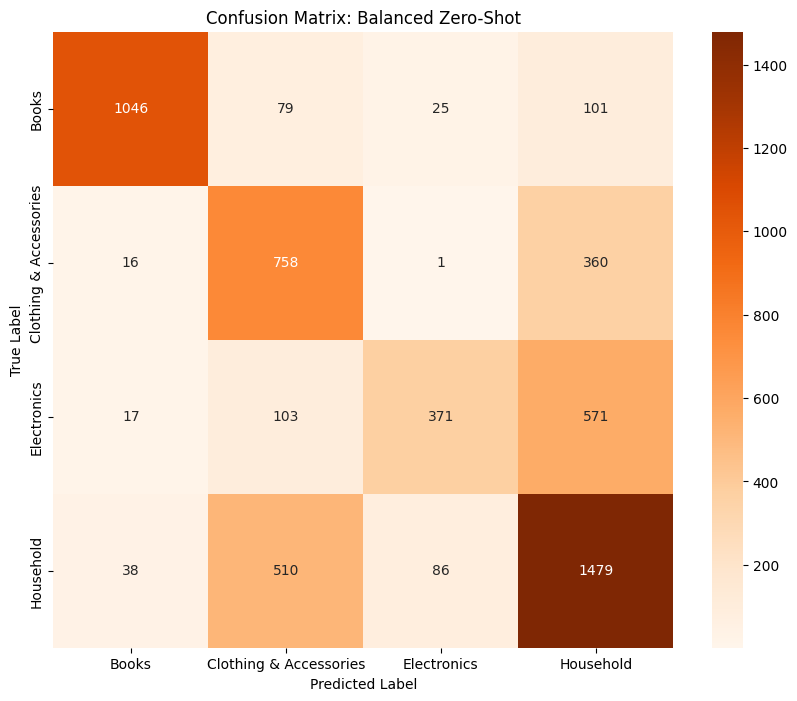


Zero-Shot Accuracy (Balanced): 0.6571


In [52]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print('--- Zero-Shot Classification Report (Balanced Descriptions) ---')
print(classification_report(y_val_cls, zero_shot_preds, target_names=target_names))

cm_zs = confusion_matrix(y_val_cls, zero_shot_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_zs,
    annot=True,
    fmt='d',
    cmap='Oranges',
    xticklabels=target_names,
    yticklabels=target_names
)
plt.title('Confusion Matrix: Balanced Zero-Shot')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

zs_accuracy = (zero_shot_preds == y_val_cls).mean()
print(f'\nZero-Shot Accuracy (Balanced): {zs_accuracy:.4f}')